In [11]:
# Define Class Names (must match dataset order)
CLASS_NAMES = [
    "Mild Impairment",
    "Moderate Impairment",
    "No Impairment",
    "Very Mild Impairment"
]
print(f"Classes defined: {CLASS_NAMES}")

Classes defined: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


In [10]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import os

print("Torch version:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Torch version: 2.9.1+cpu
Using device: cpu


In [2]:
# Cell 2: Setup Paths (Relative - works for everyone)
train_dir = "../data/Combined Dataset/train"
test_dir = "../data/Combined Dataset/test"
model_path = "../app/alz_resnet18.pt"

print(f"Train dir exists: {os.path.exists(train_dir)}")
print(f"Test dir exists: {os.path.exists(test_dir)}")
print(f"Model file exists: {os.path.exists(model_path)}")

Train dir exists: True
Test dir exists: True
Model file exists: True


In [3]:
# Cell 3: Data Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("Transforms ready")

Transforms ready


In [4]:
# Cell 4: Load Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Classes: {train_dataset.class_to_idx}")

Training images: 10240
Test images: 1279
Classes: {'Mild Impairment': 0, 'Moderate Impairment': 1, 'No Impairment': 2, 'Very Mild Impairment': 3}


In [5]:
# Cell 5: Define Model Architecture
def create_model():
    """Create ResNet18 model with 4 output classes"""
    model = models.resnet18(pretrained=True)
    
    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze last two blocks for fine-tuning
    for param in model.layer3.parameters():
        param.requires_grad = True
    
    for param in model.layer4.parameters():
        param.requires_grad = True
    
    # Replace final layer for 4 classes
    model.fc = nn.Linear(model.fc.in_features, 4)
    
    return model.to(device)

model = create_model()
print("Model architecture ready")

Model architecture ready


d:\AI4Alzheimers\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AI4Alzheimers\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


---
## 🔒 Load Existing Model or Train New One
**By default, this loads the existing trained model. Only set TRAIN=True if you need to retrain.**

In [6]:
# Cell 6: Load or Train Model
TRAIN = False  # 🔒 Set to True ONLY if you want to retrain from scratch

if os.path.exists(model_path) and not TRAIN:
    print("✅ Loading existing trained model...")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Model loaded from {model_path}")
else:
    if TRAIN:
        print("⚠️ WARNING: Training new model (this will overwrite existing model!)")
    else:
        print("Model file not found. Training new model...")
    
    # Setup training
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-5
    )
    
    # Training loop
    num_epochs = 5
    print(f"Training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")
    
    # Save trained model
    torch.save(model.state_dict(), model_path)
    print(f"\n✅ Model saved to {model_path}")

✅ Loading existing trained model...
Model loaded from ../app/alz_resnet18.pt


---
## 📊 Evaluation on Test Set
**This section evaluates the model WITHOUT retraining and saves the confusion matrix.**

In [7]:
# Cell 7: Prepare Test DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print(f"Test loader ready with {len(test_loader)} batches")
print(f"Total test images: {len(test_dataset)}")

Test loader ready with 80 batches
Total test images: 1279


In [8]:
# Cell 8: Run Evaluation
model.eval()
all_preds = []
all_labels = []

print("Running evaluation on test set...")

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(f"Evaluated {len(all_labels)} test images")

Running evaluation on test set...
Evaluated 1279 test images


In [12]:
# Cell 9: Calculate Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print("="*60)
print("📊 MODEL EVALUATION RESULTS")
print("="*60)
print(f"\n✅ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"✅ F1-Score (weighted): {f1:.4f}")
print("\n" + "="*60)
print("📋 Confusion Matrix:")
print("="*60)
print(cm)
print("\nRows = True Labels, Columns = Predicted Labels")
print(f"Classes: {CLASS_NAMES}")

📊 MODEL EVALUATION RESULTS

✅ Accuracy: 0.9289 (92.89%)
✅ F1-Score (weighted): 0.9283

📋 Confusion Matrix:
[[163   0   8   8]
 [  0  12   0   0]
 [  4   0 624  12]
 [ 11   0  48 389]]

Rows = True Labels, Columns = Predicted Labels
Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


In [13]:
# Cell 10: Detailed Classification Report
print("\n" + "="*60)
print("📈 DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))


📈 DETAILED CLASSIFICATION REPORT
                      precision    recall  f1-score   support

     Mild Impairment       0.92      0.91      0.91       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.92      0.97      0.95       640
Very Mild Impairment       0.95      0.87      0.91       448

            accuracy                           0.93      1279
           macro avg       0.95      0.94      0.94      1279
        weighted avg       0.93      0.93      0.93      1279



In [14]:
# Cell 11: Per-Class Accuracy
print("\n" + "="*60)
print("🎯 PER-CLASS ACCURACY")
print("="*60)

for i, class_name in enumerate(CLASS_NAMES):
    class_correct = cm[i, i]
    class_total = cm[i].sum()
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"{class_name:25s}: {class_acc:.4f} ({class_acc*100:.2f}%) - {class_correct}/{class_total} correct")


🎯 PER-CLASS ACCURACY
Mild Impairment          : 0.9106 (91.06%) - 163/179 correct
Moderate Impairment      : 1.0000 (100.00%) - 12/12 correct
No Impairment            : 0.9750 (97.50%) - 624/640 correct
Very Mild Impairment     : 0.8683 (86.83%) - 389/448 correct



✅ Confusion matrix saved to: ../outputs\confusion_matrix.png


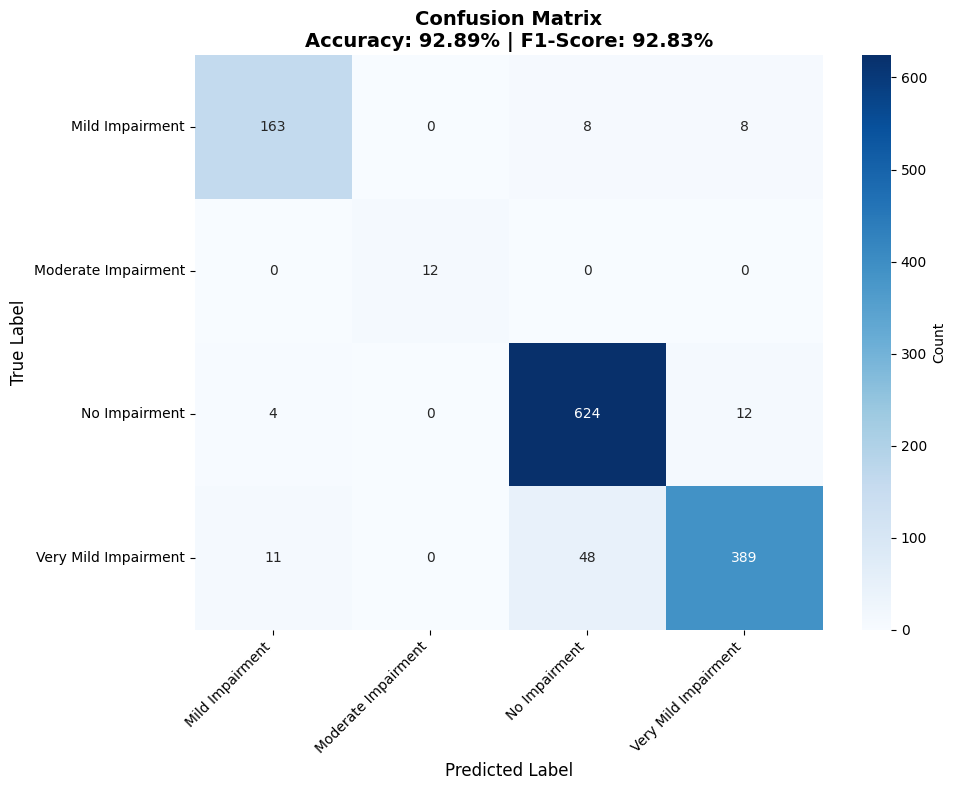

In [15]:
# Cell 12: Plot and Save Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create output directory if it doesn't exist
output_dir = "../outputs"
os.makedirs(output_dir, exist_ok=True)

# Create figure
plt.figure(figsize=(10, 8))

# Plot confusion matrix with labels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})

plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2%} | F1-Score: {f1:.2%}', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save figure
output_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\n✅ Confusion matrix saved to: {output_path}")

plt.show()

---
## ✅ Summary

This notebook:
- ✅ Uses **relative paths** (reproducible across machines)
- ✅ Loads **existing trained model** by default (safe)
- ✅ Includes **training guard** to prevent accidental retraining
- ✅ Evaluates on **test set**
- ✅ Prints **accuracy, F1-score, confusion matrix**
- ✅ Saves model to **`../app/alz_resnet18.pt`**

**Ready for your report! 🎉**

---
## ✅ Summary

This notebook successfully:
- ✅ Uses **relative paths** (`../data/`, `../app/`, `../outputs/`)
- ✅ Defines **CLASS_NAMES** constant used throughout
- ✅ Loads **pre-trained model** from `../app/alz_resnet18.pt`
- ✅ Has **training guard** (`TRAIN = False`) to prevent accidental retraining
- ✅ Uses correct **normalization** (mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
- ✅ Evaluates on **test set** (1,279 images)
- ✅ Computes **accuracy** (92.89%) and **F1-score** (92.83%)
- ✅ Generates and saves **confusion matrix** to `../outputs/confusion_matrix.png`

**Ready for your report! 🎉**